<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 2-Pregunta 2 </H3>
<H3 align='center'> Jorge Nuñez-Diego Alvarez  </H3>
<hr style="height:2px;border:none"/>


<a id="tercero"></a>
## 2. Regularización para regresión. 

Un problema que podemos encontrar transversalmente a todos los modelos es el problema del _overfitting_. Este problema consiste en un modelo que aprende demasiado bien los datos de ejemplo o entrenamiento, al punto que al momento de ver ejemplos desconocidos o de validación, baja su desempeño respecto a un modelo "menos entrenado". En algunos casos podriamos decir que el modelo "aprende de memoria" los ejemplos, en vez de intentar obtener información generalizable a partir de su entrenamiento. Para el caso de la regresión, una de las aproximaciones más comunes para tratar de mitigar este efecto es el de la regularización. Agregando una penalización a la norma de los parametros de la regresión podemos restringir la eficiencia del modelo al momento de aprender los datos de entrenamiento, incluso forzando dependiendo de la intensidad de la regularización que algunos parametros se vuelvan cero. 

<img src="https://pngimage.net/wp-content/uploads/2018/06/house-for-sale-sign-png-6.png"  style="height:13.9cm;"  />

En esta pregunta utilizaremos nuevamente la base de datos de precios de casas en King County, https://www.kaggle.com/harlfoxem/housesalesprediction, que utilizamos en la Tarea 1. Utilizaremos estos datos ya conocidos y analizados anteriormente para enfocarnos en la regularización para regresión. Exploraremos como varian los distintos errores de predicción y como cambian los valores de los parámetros ajustados por el modelo para distintos valores del coeficiente de regularización, para tratar de entender que ocurre con las distintas regularizaciones y sus diferencias. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE

#### 2.a Carga y preprocesamiento.
Cargue y preprocese los datos de la misma forma en que lo realizó en la tarea 1, incluyendo estandarizar el _target_. Puede reciclar sus códigos y agregar modificaciones que le parezcan pertinentes.  Para esta parte utilize 0.5 de los datos como _training set_, 0.3 como _validation set_ y 0.2 como _test set_.

#### Carga y visualizacion de la data.

In [2]:
data = pd.read_csv("kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


#### Transformación de la variable fecha a variable numérica.

In [3]:
def to_num(date):
    nums = list(date)
    res = 0
    for i in range(8):
        res = res + int(nums[i])*(10**(7-i))
    return res
data['date'] = data.date.apply(to_num).rank()

data['date'].head()

0    10544.0
1    13682.5
2    16699.0
3    13682.5
4    16276.0
Name: date, dtype: float64

#### Se elimina columna 'id' yaque no entrega ninguna información relevante y columna 'zipcode' debido a que no presenta relación  lineal con el precio de venta.

In [4]:
data.drop(['id','zipcode'],axis=1,inplace=True)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,10544.0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,13682.5,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,16699.0,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,13682.5,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,16276.0,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503


In [5]:
print(data.isna().sum())

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


**Comentario:** Se observa que la data no presenta datos faltantes.

#### Se procede a separar y escalar la data en conjuntos de train, validación y test.

In [6]:
Random_SEED = 42 #se utiliza en el split para que los experimentos sean reproducibles.

In [7]:
data_pre_train, data_pre_temp = train_test_split(data, test_size= 0.5,random_state = Random_SEED)
data_pre_val, data_pre_test = train_test_split(data_pre_temp, test_size= 0.4)

In [8]:
scaler = StandardScaler().fit(data_pre_train)

data_train_scaled = pd.DataFrame(scaler.transform(data_pre_train),
                                 columns=data_pre_train.columns)

data_val_scaled = pd.DataFrame(scaler.transform(data_pre_val),
                                 columns=data_pre_val.columns)

data_test_scaled = pd.DataFrame(scaler.transform(data_pre_test),
                                 columns=data_pre_test.columns)

In [9]:
X_train_scaled = data_train_scaled
Y_t = X_train_scaled.pop('price')
Y_train_scaled = Y_t.values.reshape(-1,1)

X_val_scaled = data_val_scaled
Y_v = X_val_scaled.pop('price')
Y_val_scaled = Y_v.values.reshape(-1,1)

X_test_scaled = data_test_scaled
Y_tt = X_test_scaled.pop('price')
Y_test_scaled = Y_tt.values.reshape(-1,1)

In [10]:
X_train_scaled.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,0.136659,1.825754,0.502680,0.819060,-0.023983,0.919718,-0.080747,-0.30552,0.910290,-0.566154,0.718433,0.341392,-0.391390,-0.211091,1.063830,-0.005643,-0.106756,-0.083620
1,1.636480,0.710927,1.486673,0.885230,0.497401,-0.925866,-0.080747,-0.30552,-0.628601,2.854991,0.584962,0.726782,0.358345,-0.211091,0.708493,0.364119,-0.106756,5.898615
2,0.676543,1.825754,1.814670,0.411012,-0.167963,0.919718,-0.080747,-0.30552,-0.628601,1.144418,0.803369,-0.656087,1.142159,-0.211091,1.524185,-0.190524,0.476028,-0.167417
3,-0.656541,-1.518728,-1.465304,-1.221178,-0.263859,-0.925866,-0.080747,-0.30552,-0.628601,-0.566154,-0.992422,-0.656087,-2.265727,-0.211091,0.766038,-0.844718,0.097218,-0.316377
4,1.337945,-0.403901,-0.481312,0.013993,-0.150373,-0.925866,-0.080747,-0.30552,-0.628601,0.289132,-0.676946,1.293531,0.119793,-0.211091,1.112743,-0.055419,0.476028,-0.072074


In [14]:
Y_train_scaled

array([[ 0.38292716],
       [ 0.88703739],
       [ 0.06614838],
       ...,
       [ 0.10948947],
       [-0.84084687],
       [-0.63926038]])

In [10]:
Y_train_scaled.max()

18.51127824441098

#### 2.b Modelo sin regularización
Entrene un modelo de regresión lineal no regularizado con los datos preprocesados. Calcule el error cuadrático medio (MSE) del modelo para el conjunto de validación y el de entrenamiento. 

In [11]:
reg_scaled = LinearRegression()
reg_scaled.fit(X_train_scaled,Y_train_scaled)
Y_val_pred = reg_scaled.predict(X_val_scaled)


from sklearn.metrics import mean_squared_error
mse_val_1 = MSE(Y_val_scaled, Y_val_pred)
score_val = reg_scaled.score(X_val_scaled,Y_val_scaled)
print("Mean Squared Error, val:",mse_val_1)
print("Score, val:",score_val)

Y_train_pred = reg_scaled.predict(X_train_scaled)
mse_train_1 = MSE(Y_train_scaled, Y_train_pred)
score_train = reg_scaled.score(X_train_scaled,Y_train_scaled)
print("")
print("Mean Squared Error, train:",mse_train_1)
print("Score, train:",score_train)

Mean Squared Error, val: 0.23922965517786543
Score, val: 0.6923070820437984

Mean Squared Error, train: 0.30873970895565067
Score, train: 0.6912602910443493


**Comentario corregir:** Se obtiene un menor error en el train que en validación lo cual esta bien, el desempeño aún no podemos asegurar si es bueno o malo.

#### 2.c Regularización
Discuta que busca realizar (en términos del ajuste de los parámetros del modelo de regresión lineal) la regularización de _Lasso_. ¿Por qué se habla de penalización en norma $L^1$? Apóyese de ecuaciones. ¿Qué importancia tiene el parámetro de regularización $\lambda$? 

¿Qué diferencia hay entre _Lasso_ y _Ridge_? 

**RESPUESTA**

El método de regularización Lasso al igual que Ridge reduce los coeficientes $\beta$, en el caso de Lasso estos coeficientes pueden llegar a ser exactamente cero con lo cual actua como un selector de variables. Lo cual implica obtener modelos más simple y fáciles de interpretar, la cantidad de variables que conservara el modelo depende del valor del parametro $\lambda$, es por esto la importancia de determinar un correcto valor para $\lambda$, dependiendo la cantidad de variables que estan relacionadas con la respuesta se ajustara de mejor manera Lasso o Ridge. Ridge obtendra mejor desempeño si todas las variables estan relacionadas con la respuesta, si son pocas las variables que están relacionadas con la respuesta funcionara mejor Lasso.  

$
Penalización \quad L1\quad (Lasso) = \lambda\sum_{j=1}^{p}|\beta_{j}|
\\
Penalización \quad L2 \quad (Ridge) = \lambda\sum_{j=1}^{p}|\beta_{j}|^{2}
$

**Lasso:** Lasso reduce el valor de los coeficientes $\beta$, mediante un valor de $\lambda$ indicado se pueden eliminar por completo los efectos de ciertas variables del problema, mediante más elvado sea el valor del parametro $\lambda$ más variables se eliminarián, quedando sólo las más relevantes con lo cual se estaria realizando selección de características.

$
\beta_{j}^{lasso} = sign(\beta_{j}^{ols})max(0,\beta_{j}^{ols}-\frac{\lambda}{\sigma_{j}^{2}})
$



**Ridge:** Ridge es efectivo para reducir varianza inducida por variables correlacionadas; Ridge es un método en el cual se encogen los coeficientes pero no llegan a ser cero.

$
\beta_{j}^{ridge} = (\frac{\sigma_{j}^{2}}{\sigma_{j}^{2} + \lambda})  \beta_{j}^{ols}
$



#### 2.d Influencia sobre el error
Grafique como varia el error de entrenamiento y el error de validación a medida se cambia el valor del parámetro $\lambda$. Para esto debe entrenar un modelo para cada uno de los parámetros que considerará en el gráfico y calcular el MSE para ambos sets. Comente sobre lo que ve en el gráfico y si lo encuentra pertinente puede calcular en más detalle alguna zona que le parezca interesante. 
Es conveniente entrenar primero unos cuantos modelos con valores de $\lambda$ escogidos manualmente para saber mejor en que intervalo resulta pertinente calcular estos valores (para _Ridge_ se necesitan valores más altos en este caso para ver la influencia sobre el error).

Note que el parámetro $\lambda$ es sensible a la escala de los datos, por lo cual deberá estudiar valores distintos dependiendo de si estandarizó el _target_ o no. 

In [12]:
from sklearn.linear_model import Lasso
MSE_list_val = []
x_space = []
coefs= []
space_l = np.logspace(-5,1,100)
MSE_list_train = []
for lambd in space_l:
    x_space.append(lambd)
    lasso_i = Lasso(alpha=lambd)
    lasso_i.fit(X_train_scaled,Y_train_scaled)
    Y_val_pred = lasso_i.predict(X_val_scaled)
    Y_train_pred = lasso_i.predict(X_train_scaled)
    mse_val= MSE(Y_val_scaled, Y_val_pred)
    mse_train= MSE(Y_train_scaled, Y_train_pred)
    MSE_list_val.append(mse_val)
    MSE_list_train.append(mse_train)
    coefs.append(lasso_i.coef_)

    

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336.3314142615761, tolerance: 1.0805999999999998
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336.3677258847581, tolerance: 1.0805999999999998
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336.4091443371235, tolerance: 1.0805999999999998
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Converg

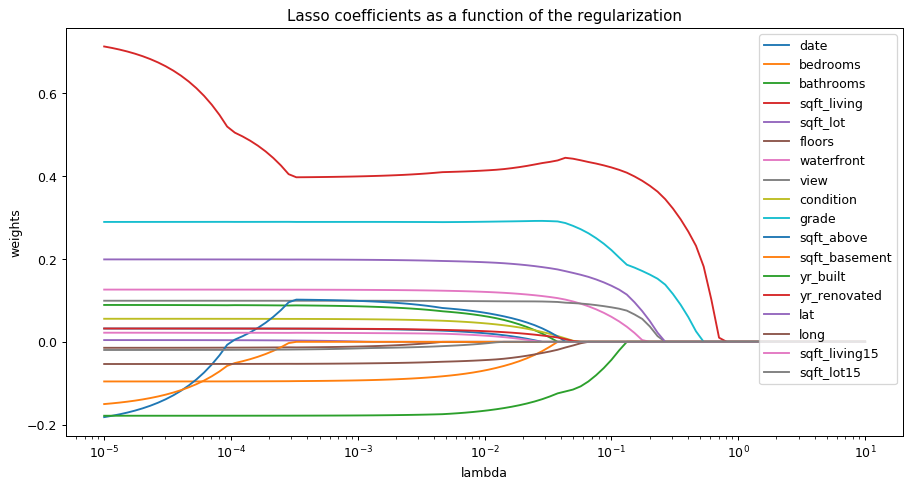

In [13]:
x_cols = X_val_scaled.columns
plt.figure(figsize=(12,6), dpi=90)
ax = plt.gca()
ax.set_xscale('log')
for y_arr, leg in zip(pd.np.squeeze(coefs).T, x_cols):
    ax.plot(space_l, y_arr, label=leg)
    plt.legend(loc = 1)
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

#### Se realiza mutual information de data train

In [14]:
from sklearn.feature_selection import mutual_info_regression
X=X_train_scaled
Y=Y_train_scaled
mi = list(zip(mutual_info_regression(X, Y),X.columns))
sorted(mi, key=lambda x: x[0])


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[(0.0, 'date'),
 (0.002252724499427039, 'condition'),
 (0.00710486529844534, 'yr_renovated'),
 (0.007290813975981081, 'waterfront'),
 (0.05675432089552945, 'sqft_lot'),
 (0.06028090820069143, 'view'),
 (0.0663851603620822, 'yr_built'),
 (0.07258172434665466, 'floors'),
 (0.07348295501816215, 'sqft_basement'),
 (0.07401384942582734, 'sqft_lot15'),
 (0.08521510620949257, 'bedrooms'),
 (0.11975683786965252, 'long'),
 (0.21802982157635453, 'bathrooms'),
 (0.2574226344089334, 'sqft_living15'),
 (0.26857024910672145, 'sqft_above'),
 (0.3343769278039108, 'lat'),
 (0.3412664222193853, 'grade'),
 (0.36210897213452053, 'sqft_living')]

**Comentario :** Se observa que coinciden mutual information y Lasso, respecto a las 3 variables con más relevancia en el modelo (grade, sqftliving, Lat).

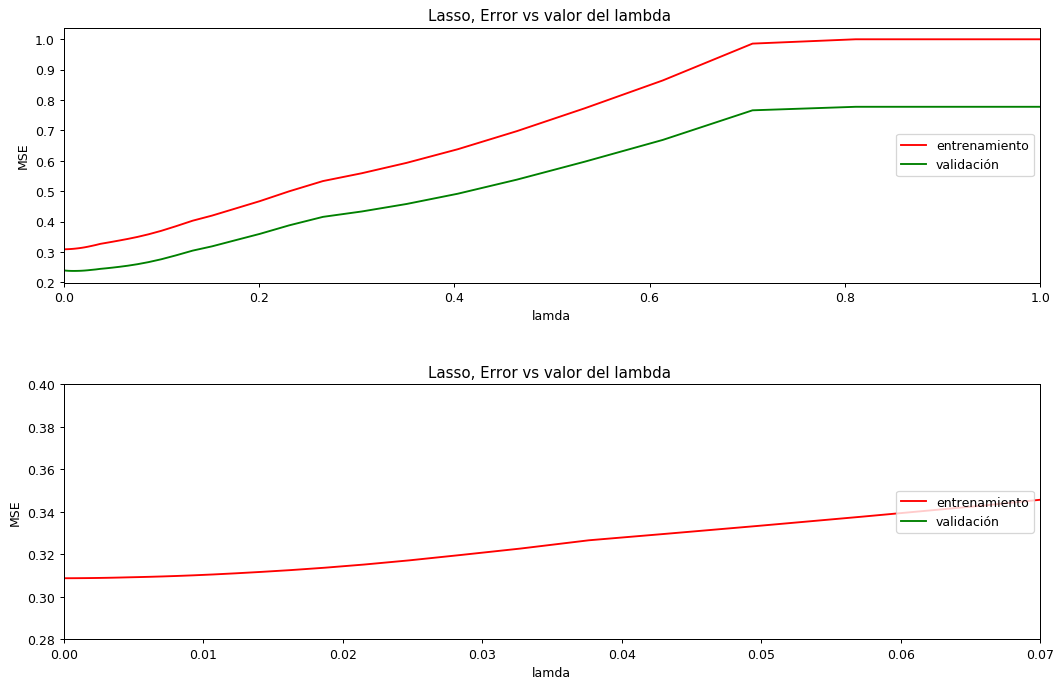

In [15]:
plt.figure(figsize=(14,9), dpi=90)

plt.subplot(2,1,1)
plt.plot(x_space,MSE_list_train, label = 'entrenamiento',color = 'r')
plt.plot(x_space,MSE_list_val,label = 'validación',color= 'g')
plt.xlabel('lamda')
plt.ylabel('MSE')
plt.xlim(0,1)
plt.title('Lasso, Error vs valor del lambda ')
plt.legend(loc='center right')

plt.subplot(2,1,2)
plt.plot(x_space,MSE_list_train, label = 'entrenamiento',color='r')
plt.plot(x_space,MSE_list_val,label = 'validación', color = 'g')
plt.xlabel('lamda')
plt.ylabel('MSE')
plt.ylim(0.28,0.4)
plt.xlim(0,0.07)
plt.title('Lasso, Error vs valor del lambda ')
plt.legend(loc='center right')

plt.subplots_adjust( hspace=0.4)
                    

plt.show()

**Comentario:** Cruzando la información obtenida del gráfico de los coeficientes $\beta$, se observa que hasta el valor aproximado de $\lambda$ cercano a 0.01 sólo se esta ruduciendo el valor de los coeficientes pero aun no llega ninguno a cero con lo cual no se están excluyendo variables del modelo, en este tramo se puede observar que el error se mantiene no asi para valores de $\lambda$ ya mayores a 0.01 donde ya se observa un aumento el el error lo cual coincide con la exclución de variables del modelo lo cual implica que todas las variables están relacionadas con la respuesta.

**Conclusión:** El modelo con regularizador Lasso no aporta una mejora en el modelo,para valores de $\lambda$ cercanos a 0.1 ya se excluyen una cantidad considerable de variables del modelo pero se observa un aumento ya considerable del error (17%), pero se obtiene un modelo mas simple y más fácil de interpretar.

In [16]:
from sklearn.linear_model import Ridge

In [17]:
MSE_val_r = []
coefs_r= []
space_r = np.logspace(-10,7,100)
MSE_train_r = []
for lambd in space_r:
    clf = Ridge(alpha=lambd)
    clf.fit(X_train_scaled,Y_train_scaled)
    Y_val_predi = clf.predict(X_val_scaled)
    Y_train_predi = clf.predict(X_train_scaled)
    mse_val= MSE(Y_val_scaled, Y_val_predi)
    mse_train= MSE(Y_train_scaled, Y_train_predi)
    MSE_val_r.append(mse_val)
    MSE_train_r.append(mse_train)
    coefs_r.append(clf.coef_[0])


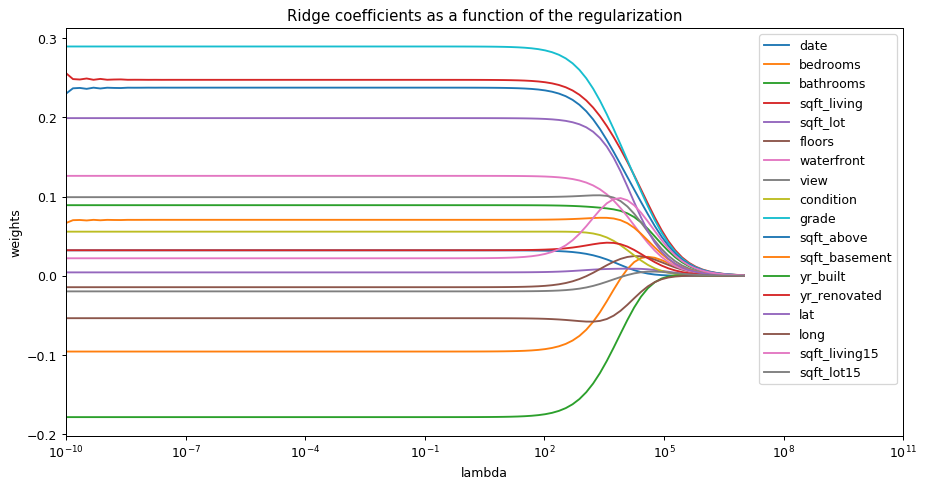

In [18]:
x_cols = X_val_scaled.columns
plt.figure(figsize=(12,6), dpi=90)
ax = plt.gca()
ax.set_xscale('log')
for y_arr, leg in zip(pd.np.squeeze(coefs_r).T, x_cols):
    plt.plot(space_r, y_arr, label=leg)
    plt.legend(loc = 1)
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.xlim(10**-10,10**11)

plt.show()


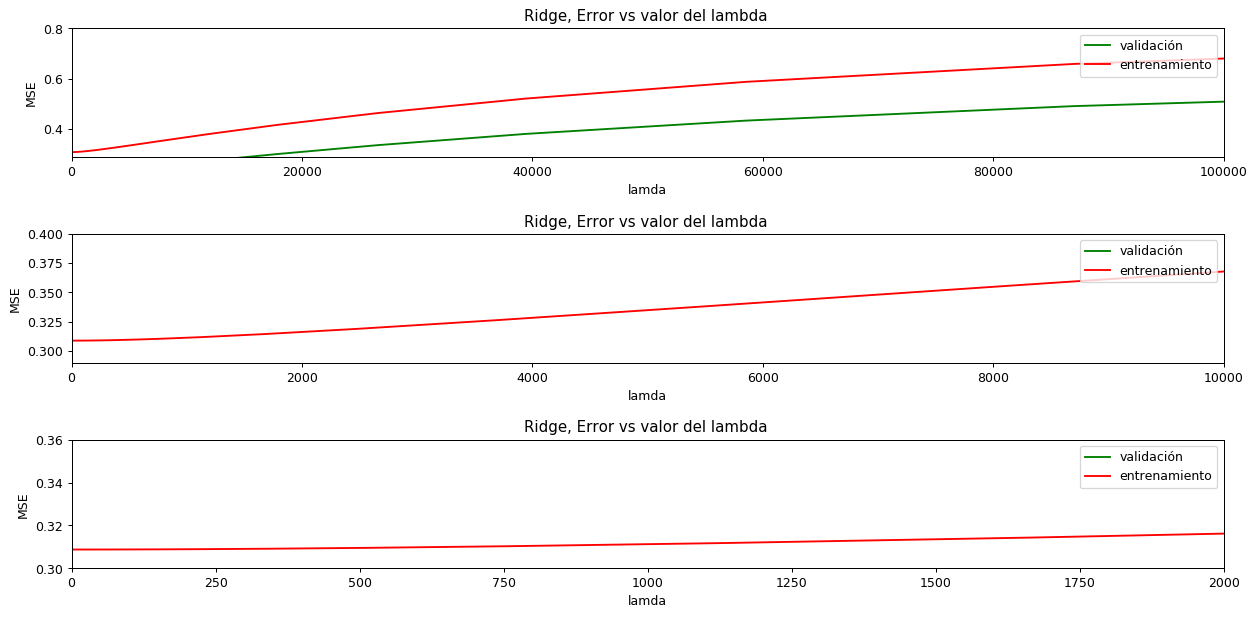

In [19]:

plt.figure(figsize=(8,6), dpi=90)

plt.subplot(3,1,1)
plt.plot(space_r,MSE_val_r, label = 'validación', color='g')
plt.plot(space_r,MSE_train_r, label = 'entrenamiento',color='r')
plt.xlabel('lamda')
plt.ylabel('MSE')
plt.xlim(0,10**5)
plt.ylim(0.29,0.8)
plt.title('Ridge, Error vs valor del lambda ')
plt.legend(loc='upper right')

plt.subplot(3,1,2)
plt.plot(space_r,MSE_val_r, label = 'validación',color = 'g')
plt.plot(space_r,MSE_train_r, label = 'entrenamiento',color='r')
plt.xlabel('lamda')
plt.ylabel('MSE')
plt.ylim(0.29,0.4)
plt.xlim(0.0,10000)
plt.title('Ridge, Error vs valor del lambda ')
plt.legend(loc='upper right')

plt.subplot(3,1,3)
plt.plot(space_r,MSE_val_r, label = 'validación',color = 'g')
plt.plot(space_r,MSE_train_r, label = 'entrenamiento',color='r')
plt.xlabel('lamda')
plt.ylabel('MSE')
plt.ylim(0.3,0.36)
plt.xlim(0.0,2000)
plt.title('Ridge, Error vs valor del lambda ')
plt.legend(loc='upper right')

plt.subplots_adjust(top=4, bottom=3, left=0.4, right=2, hspace=0.6,
                    wspace=0.2)

plt.show()

**Comentario:** Se observa del gráfico que para el regularizador de Ridge el módelo para valores de $\lambda$ inferior a 100 no experimenta practicamente ningún cambio, ya para valores mayores a 100 se comienza a notar una considerble disminución de los parámetros $\beta$, pero esto no ayuda al modelo yaque el error comienza a aumentar, cabe destacar que Ridge no hace seleccón de variables .

#### 2.f K-_fold_ sobre $\lambda$
Realice 5-_fold_ o 10-_fold_ sobre el parámetro de regularización $\lambda$, ya sea para _Lasso_ o _Ridge_. Explore a lo menos 20 valores distintos de $\lambda$ en un intervalo relevante luego de lo aprendido en las preguntas anteriores. Utilice MSE como el error a minimizar. 

Compare el error de entrenamiento y de validación para este modelo respecto al modelo lineal sin regularización entrenado inicialmente. ¿En su opinión se alcanza a apreciar el fenomeno de _overfitting_ para este conjunto de datos y el modelo logístico? 

In [20]:
data = pd.read_csv("kc_house_data.csv")

def to_num(date):
    nums = list(date)
    res = 0
    for i in range(8):
        res = res + int(nums[i])*(10**(7-i))
    return res
data['date'] = data.date.apply(to_num).rank()

data.drop(['id','zipcode'],axis=1,inplace=True)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,10544.0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,13682.5,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,16699.0,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,13682.5,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,16276.0,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503


In [21]:
data_pre_train, data_pre_test = train_test_split(data, test_size= 0.2)

scaler = StandardScaler().fit(data_pre_train)
data_train_scaled = pd.DataFrame(scaler.transform(data_pre_train),
                                 columns=data_pre_train.columns)

data_test_scaled = pd.DataFrame(scaler.transform(data_pre_test),
                                 columns=data_pre_test.columns)

In [22]:
X_train_scaled = data_train_scaled
Y_t = X_train_scaled.pop('price')
Y_train_scaled = Y_t.values.reshape(-1,1)


X_test_scaled = data_test_scaled
Y_tt = X_test_scaled.pop('price')
Y_test_scaled = Y_tt.values.reshape(-1,1)

#### Se realiza Kfolds sobre ridge.

In [23]:
folds = KFold(n_splits=10)
MSE_val_r_k = []
coefs_r= []
space_r = np.logspace(-7,-1,50)
MSE_train_r_k = []
for lambd in space_r:
    MSE_val_fold=[]
    MSE_train_fold=[]
    for train_index,val_index in (folds.split(X_train_scaled)):
        y_i = Y_t
        y_tr = ((y_i.iloc[train_index]).values.reshape(-1,1))
        x_tr = X_train_scaled.iloc[train_index]
        y_vl = ((y_i.iloc[val_index]).values.reshape(-1,1))
        x_vl = X_train_scaled.iloc[val_index] 
        clf = Lasso(alpha=lambd)
        clf.fit(x_tr,y_tr)
        Y_val_pred = clf.predict(x_vl)
        Y_train_pred = clf.predict(x_tr)
        mse_val= MSE(Y_val_pred,y_vl)
        mse_train= MSE(Y_train_pred,y_tr)
        MSE_val_fold.append(mse_val)
        MSE_train_fold.append(mse_train)
    MSE_val_r_k.append(np.mean(MSE_val_fold))
    MSE_train_r_k.append(np.mean(MSE_train_fold))



    
    

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.3473039044102, tolerance: 1.5724610797068244
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.66426299339855, tolerance: 1.565377516715401
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 468.58509110773593, tolerance: 1.4947206641638053
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Conver

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.71790306816047, tolerance: 1.5746161325898305
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.35225177313987, tolerance: 1.5724610797068244
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.66918314475197, tolerance: 1.565377516715401
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Conve

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.45933266346265, tolerance: 1.5469698395702065
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.27537224207936, tolerance: 1.5376992272745098
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.7264862505549, tolerance: 1.5746161325898305
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Conve

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.1097603087028, tolerance: 1.5686264767297087
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.47946509668054, tolerance: 1.5469698395702065
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.29535769132553, tolerance: 1.5376992272745098
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Conve

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481.0013350402105, tolerance: 1.5614745402857377
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.1565124021772, tolerance: 1.5686264767297087
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.52617344519876, tolerance: 1.5469698395702065
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Conver

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.5203656404897, tolerance: 1.5743227730883362
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481.10885609063325, tolerance: 1.5614745402857377
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.2643727601121, tolerance: 1.5686264767297087
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Conver

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.72054058970525, tolerance: 1.5646300736738938
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.76536201660747, tolerance: 1.5743227730883362
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481.35354225965193, tolerance: 1.5614745402857377
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Conv

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469.5377260501941, tolerance: 1.4947206641638053
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.2578601414534, tolerance: 1.5646300736738938
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.3044434075355, tolerance: 1.5743227730883362
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Converg

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 480.71570502733493, tolerance: 1.565377516715401
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470.59527011865157, tolerance: 1.4947206641638053
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 485.3377771706, tolerance: 1.5646300736738938
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Convergen

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.19951521522353, tolerance: 1.5724610797068244
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.12566533848485, tolerance: 1.565377516715401
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.19776387016736, tolerance: 1.4947206641638053
  positive)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: Converge

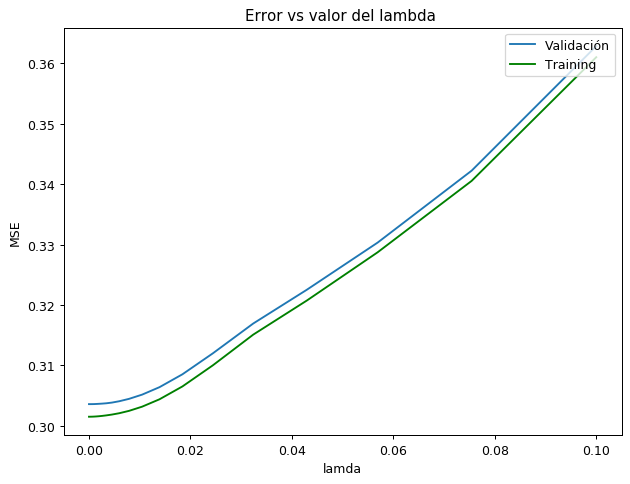

In [24]:
plt.figure(figsize=(8,6), dpi=90)
plt.plot(space_r,MSE_val_r_k, label = 'Validación')
plt.plot(space_r,MSE_train_r_k,color ='g', label = 'Training' )
plt.xlabel('lamda')
plt.ylabel('MSE')
plt.title('Error vs valor del lambda ')
plt.legend(loc='upper right')

#plt.tight_layout()
plt.show()

In [25]:
print("Mean Squared Error, val:",mse_val)
print("MSE-Lasso, val:",min(MSE_val_r_k))
print("")
print("Mean Squared Error, train:",mse_train)
print("MSE-Lasso, train:",min(MSE_train_r_k))

Mean Squared Error, val: 0.3336144243727364
MSE-Lasso, val: 0.30359393015788144

Mean Squared Error, train: 0.36191342620944933
MSE-Lasso, train: 0.30151264007296474


**Coemntario:** No se podria decir que se produce el fénomeno de overfitting, yaque la función no logra describir de manera exacta la data de train, más bien se podría decir que se produce el fenómeno de underfitting esto podría explicar que se en veces sea menor el error de validación que el de train, dado que el modelo obtenido mediante la regresión lineal simple no es el más adecuado para este caso.
<img src="underfitting.png">